### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import math

import datetime as dt
from datetime import date

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.ion()
plt.style.use('seaborn')

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn import utils

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

import warnings
warnings.filterwarnings('ignore')

import gc
gc.collect()

41

### Loading the Data

In [5]:
  ## Loading the data from a csv file
data = pd.read_csv(r"C:\Users\vrade\OneDrive\Applied Research Project In Actuarial Science\Sem 2- Analysis & Results\Stocks\Telecommunication & Technology\Safaricom\Safaricom.csv", sep=r'\s*,\s*', header=0, encoding='ascii', engine='python')
data= data.reindex(index= data.index[::-1])
data.reset_index(inplace= True)
data.drop(['index','Volume'], axis= 1, inplace= True)
data

,Date,Open,High,Low,Close
0,01/02/13,5.0,5.15,5.00,5.10
1,01/03/13,5.1,5.25,5.10,5.15
2,01/04/13,5.2,5.35,5.15,5.25
3,01/07/13,5.2,5.45,5.20,5.35
4,01/08/13,5.4,5.85,5.40,5.60
...,...,...,...,...,...
2451,10/26/22,24.5,25.25,24.50,24.95
2452,10/27/22,25.4,25.50,25.00,25.30
2453,10/28/22,25.5,25.50,24.60,24.85
2454,10/31/22,25.5,25.50,24.80,25.10


### Technical Indicator Features

In [6]:
## Simple Moving Average
data['SMA Close (F)']= ta.sma(data["Close"], length= 21)
data['SMA Close (M)']= ta.sma(data['Close'], length= 75)
data['SMA Close (S)']= ta.sma(data['Close'], length= 150)


## Exponential Moving Average
data['EMA Close (F)']= ta.ema(data["Close"], length= 21)
data['EMA Close (M)']= ta.ema(data['Close'], length= 75)
data['EMA Close (S)']= ta.ema(data['Close'], length= 150)


## Double Exponential Moving Average
data['DEMA Close (F)']= ta.dema(data["Close"], length= 21)
data['DEMA Close (M)']= ta.dema(data['Close'], length= 75)
data['DEMA Close (S)']= ta.dema(data['Close'], length= 150)


## Triple Exponential Movng Average
data['TEMA Close (F)']= ta.tema(data["Close"], length= 21)
data['TEMA Close (M)']= ta.tema(data['Close'], length= 75)
data['TEMA Close (S)']= ta.tema(data['Close'], length= 150)


## Kaufman Adaptive Moving Average
data['KAMA Close (F)']= ta.kama(data["Close"], length= 21)
data['KAMA Close (M)']= ta.kama(data['Close'], length= 75)
data['KAMA Close (S)']= ta.kama(data['Close'], length= 150)

## MACD
macdClose= ta.macd(data['Close'])

## Bollinger Bands
bbandsClose= ta.bbands(data['Close'])

## Momentum
data['Momentum Close']= ta.mom(data['Close'])

## Relative Strength Index
data['RSI Close']= ta.rsi(data['Close'], period= 14)

## True Range
data['TrueRange']= ta.true_range(data['High'], data['Low'], data['Close'])

## Avrerage True Range
data['AvgTrueRange']= ta.atr(data['High'], data['Low'], data['Close'])

In [7]:
bbandsCloseNames= {'BBL_5_2.0' : 'CloseLower', 
                   'BBM_5_2.0' : 'CloseMid', 
                   'BBU_5_2.0' : 'CloseUpper', 
                   'BBB_5_2.0' : 'CloseBandwidth', 
                   'BBP_5_2.0' : 'Close%Columns'}

for i in bbandsClose.columns:
    data[i]= bbandsClose[i]
data.rename(columns= bbandsCloseNames, inplace= True)

In [8]:
macdCloseNames= {'MACD_12_26_9': 'MACDClose', 
                 'MACDh_12_26_9': 'HistClose', 
                 'MACDs_12_26_9': 'SignalClose'}

for i in macdClose.columns:
    data[i]= macdClose[i]
data.rename(columns= macdCloseNames, inplace= True)

### Return Features

In [9]:
## Simple Return
data['CloseR']= data['Close']/data['Close'].shift(-1) ## target feature we want to predict
data['OpenR']= data['Open']/data['Open'].shift(-1)
data['HighR']= data['High']/data['High'].shift(-1)
data['LowR']= data['Low']/data['Low'].shift(-1)

## Lagged Return Calculations
data['CloseR (2)']= data['Close']/data['Close'].shift(-2)
data['OpenR (2)']= data['Open']/data['Open'].shift(-2)
data['HighR (2)']= data['High']/data['High'].shift(-2)
data['LowR (2)']= data['Low']/data['Low'].shift(-2)

data['CloseR (3)']= data['Close']/data['Close'].shift(-3)
data['OpenR (3)']= data['Open']/data['Open'].shift(-3)
data['HighR (3)']= data['High']/data['High'].shift(-3)
data['LowR (3)']= data['Low']/data['Low'].shift(-3)

data['CloseR (2/3)']= data['Close'].shift(-2)/data['Close'].shift(-3)
data['OpenR (2/3)']= data['Open'].shift(-2)/data['Open'].shift(-3)
data['HighR (2/3)']= data['High'].shift(-2)/data['High'].shift(-3)
data['LowR (2/3)']= data['Low'].shift(-2)/data['Low'].shift(-3)


data['CloseR (4)']= data['Close']/data['Close'].shift(-4)
data['OpenR (4)']= data['Open']/data['Open'].shift(-4)
data['HighR (4)']= data['High']/data['High'].shift(-4)
data['LowR (4)']= data['Low']/data['Low'].shift(-4)

data['CloseR (5)']= data['Close']/data['Close'].shift(-5)
data['OpenR (5)']= data['Open']/data['Open'].shift(-5)
data['HighR (5)']= data['High']/data['High'].shift(-5)
data['LowR (5)']= data['Low']/data['Low'].shift(-5)

data['CloseR (4/5)']= data['Close'].shift(-4)/data['Close'].shift(-5)
data['OpenR (4/5)']= data['Open'].shift(-4)/data['Open'].shift(-5)
data['HighR (4/5)']= data['High'].shift(-4)/data['High'].shift(-5)
data['LowR (4/5)']= data['Low'].shift(-4)/data['Low'].shift(-5)

data['CloseR (15)']= data['Close']/data['Close'].shift(-15)
data['OpenR (15)']= data['Open']/data['Open'].shift(-15)
data['HighR (15)']= data['High']/data['High'].shift(-15)
data['LowR (15)']= data['Low']/data['Low'].shift(-15)

data['CloseR (30)']= data['Close']/data['Close'].shift(-30)
data['OpenR (30)']= data['Open']/data['Open'].shift(-30)
data['HighR (30)']= data['High']/data['High'].shift(-30)
data['LowR (30)']= data['Low']/data['Low'].shift(-30)

data['CloseR (15/30)']= data['Close'].shift(-15)/data['Close'].shift(-30)
data['OpenR (15/30)']= data['Open'].shift(-15)/data['Open'].shift(-30)
data['HighR (15/30)']= data['High'].shift(-15)/data['High'].shift(-30)
data['LowR (15/30)']= data['Low'].shift(-15)/data['Low'].shift(-30)

data['High/Open']= data['High']/data['Open']
data['Low/Open']= data['Low']/data['Open']
data['High/Close']= data['High']/data['Close']
data['Low/Close']= data['Low']/data['Close']

data['High/Open (1)']= data['High']/data['Open'].shift(-1)
data['Low/Open (1)']= data['Low']/data['Open'].shift(-1)
data['High/Close (1)']= data['High']/data['Close'].shift(-1)
data['Low/Close (1)']= data['Low']/data['Close'].shift(-1)

data['High/Open (2)']= data['High']/data['Open'].shift(-2)
data['Low/Open (2)']= data['Low']/data['Open'].shift(-2)
data['High/Close (2)']= data['High']/data['Close'].shift(-2)
data['Low/Close (2)']= data['Low']/data['Close'].shift(-2)

data['High/Open (1/2)']= data['High'].shift(-1)/data['Open'].shift(-2)
data['Low/Open (1/2)']= data['Low'].shift(-1)/data['Open'].shift(-2)
data['High/Close (1/2)']= data['High'].shift(-1)/data['Close'].shift(-2)
data['Low/Close (1/2)']= data['Low'].shift(-1)/data['Close'].shift(-2)

data['High/Open (3)']= data['High']/data['Open'].shift(-3)
data['Low/Open (3)']= data['Low']/data['Open'].shift(-3)
data['High/Close (3)']= data['High']/data['Close'].shift(-3)
data['Low/Close (3)']= data['Low']/data['Close'].shift(-3)

data['High/Open (2/3)']= data['High'].shift(-2)/data['Open'].shift(-3)
data['Low/Open (2/3)']= data['Low'].shift(-2)/data['Open'].shift(-3)
data['High/Close (2/3)']= data['High'].shift(-2)/data['Close'].shift(-3)
data['Low/Close (2/3)']= data['Low'].shift(-2)/data['Close'].shift(-3)

data['High/Open (15)']= data['High']/data['Open'].shift(-15)
data['Low/Open (15)']= data['Low']/data['Open'].shift(-15)
data['High/Close (15)']= data['High']/data['Close'].shift(-15)
data['Low/Close (15)']= data['Low']/data['Close'].shift(-15)

data['High/Open (30)']= data['High']/data['Open'].shift(-30)
data['Low/Open (30)']= data['Low']/data['Open'].shift(-30)
data['High/Close (30)']= data['High']/data['Close'].shift(30)
data['Low/Close (30)']= data['Low']/data['Close'].shift(30)

data['High/Open (15/30)']= data['High'].shift(-15)/data['Open'].shift(-30)
data['Low/Open (15/30)']= data['Low'].shift(-15)/data['Open'].shift(-30)
data['High/Close (15/30)']= data['High'].shift(15)/data['Close'].shift(-30)
data['Low/Close (15/30)']= data['Low'].shift(-15)/data['Close'].shift(-30)

data['High/Open (30/30)']= data['High'].shift(-30)/data['Open'].shift(-30)
data['Low/Open (30/30)']= data['Low'].shift(-30)/data['Open'].shift(-30)
data['High/Close (30/30)']= data['High'].shift(-30)/data['Close'].shift(-30)
data['Low/Close (30/30)']= data['Low'].shift(-30)/data['Close'].shift(-30)

data['High/Open (35/35)']= data['High'].shift(-35)/data['Open'].shift(35)
data['Low/Open (35/35)']= data['Low'].shift(-35)/data['Open'].shift(-35)
data['High/Close (35/35)']= data['High'].shift(-35)/data['Close'].shift(-35)
data['Low/Close (35/35)']= data['Low'].shift(-35)/data['Close'].shift(-35)

data['High/Open (35/35)']= data['High'].shift(-35)/data['Open'].shift(35)
data['Low/Open (35/35)']= data['Low'].shift(-35)/data['Open'].shift(-35)
data['High/Close (35/35)']= data['High'].shift(-35)/data['Close'].shift(-35)
data['Low/Close (35/35)']= data['Low'].shift(-35)/data['Close'].shift(-35)

data['High/Open (37/40)']= data['High'].shift(-37)/data['Open'].shift(-40)
data['Low/Open (37/40)']= data['Low'].shift(-37)/data['Open'].shift(-40)
data['High/Close (37/40)']= data['High'].shift(-37)/data['Close'].shift(-40)
data['Low/Close (37/40)']= data['Low'].shift(-37)/data['Close'].shift(-40)

data['High/Open (39/40)']= data['High'].shift(-39)/data['Open'].shift(-40)
data['Low/Open (39/40)']= data['Low'].shift(-39)/data['Open'].shift(-40)
data['High/Close (39/40)']= data['High'].shift(-39)/data['Close'].shift(-40)
data['Low/Close (39/40)']= data['Low'].shift(-39)/data['Close'].shift(-40)

data['High/Open (38/40)']= data['High'].shift(-38)/data['Open'].shift(-40)
data['Low/Open (38/40)']= data['Low'].shift(-38)/data['Open'].shift(-40)
data['High/Close (38/40)']= data['High'].shift(-38)/data['Close'].shift(-40)
data['Low/Close (38/40)']= data['Low'].shift(-38)/data['Close'].shift(-40)

data['High/Open (40/40)']= data['High'].shift(-40)/data['Open'].shift(-40)
data['Low/Open (40/40)']= data['Low'].shift(-40)/data['Open'].shift(-40)
data['High/Close (40/40)']= data['High'].shift(-40)/data['Close'].shift(-40)
data['Low/Close (40/40)']= data['Low'].shift(-40)/data['Close'].shift(-40)

## Lagging Calculated Returns
data['RetClose']= data['CloseR'].shift(-1)
data['RetClose (2)']= data['CloseR'].shift(-2)
data['RetClose (3)']= data['CloseR'].shift(-3)
data['RetClose (5)']= data['CloseR'].shift(-5)
data['RetClose (6)']= data['CloseR'].shift(-6)
data['RetClose (15)']= data['CloseR'].shift(-15)
data['RetClose (20)']= data['CloseR'].shift(-20)
data['RetClose (30)']= data['CloseR'].shift(-30)
data['RetClose (35)']= data['CloseR'].shift(-35)
data['RetClose (40)']= data['CloseR'].shift(-40)


data['RetLow']= data['LowR'].shift(-1)
data['RetLow (2)']= data['LowR'].shift(-2)
data['RetLow (3)']= data['LowR'].shift(-3)
data['RetLow (5)']= data['LowR'].shift(-5)
data['RetLow (6)']= data['LowR'].shift(-6)
data['RetLow (15)']= data['LowR'].shift(-15)
data['RetLow (20)']= data['LowR'].shift(-20)
data['RetLow (30)']= data['LowR'].shift(-30)
data['RetLow (35)']= data['LowR'].shift(-35)
data['RetLow (40)']= data['LowR'].shift(-40)


data['RetHigh']= data['HighR'].shift(-1)
data['RetHigh (2)']= data['HighR'].shift(-2)
data['RetHigh (3)']= data['HighR'].shift(-3)
data['RetHigh (5)']= data['HighR'].shift(-5)
data['RetHigh (6)']= data['HighR'].shift(-6)
data['RetHigh (15)']= data['HighR'].shift(-15)
data['RetHigh (20)']= data['HighR'].shift(-20)
data['RetHigh (30)']= data['HighR'].shift(-30)
data['RetHigh (35)']= data['HighR'].shift(-35)
data['RetHigh (40)']= data['HighR'].shift(-40)


data['RetLow']= data['LowR'].shift(-1)
data['RetLow (2)']= data['LowR'].shift(-2)
data['RetLow (3)']= data['LowR'].shift(-3)
data['RetLow (5)']= data['LowR'].shift(-5)
data['RetLow (6)']= data['LowR'].shift(-6)
data['RetLow (15)']= data['LowR'].shift(-15)
data['RetLow (20)']= data['LowR'].shift(-20)
data['RetLow (30)']= data['LowR'].shift(-30)
data['RetLow (35)']= data['LowR'].shift(-35)
data['RetLow (40)']= data['LowR'].shift(-40)

data['RetOpen']= data['OpenR'].shift(-1)
data['RetOpen (2)']= data['OpenR'].shift(-2)
data['RetOpen (3)']= data['OpenR'].shift(-3)
data['RetOpen (5)']= data['OpenR'].shift(-5)
data['RetOpen (6)']= data['OpenR'].shift(-6)
data['RetOpen (15)']= data['OpenR'].shift(-15)
data['RetOpen (20)']= data['OpenR'].shift(-20)
data['RetOpen (30)']= data['OpenR'].shift(-30)
data['RetOpen (35)']= data['OpenR'].shift(-35)
data['RetOpen (40)']= data['OpenR'].shift(-40)

### The Dataset

In [10]:
data.drop(['Date','Open', 'High', 'Low', 'Close'], axis= 1, inplace= True)
data.dropna(inplace= True)
data.reset_index(inplace= True)
data.drop(['index'], axis= 1, inplace= True)
data['TargetCloseR']= data['CloseR'].shift(-30).fillna(0)

print('CloseR Column:', data.columns.get_loc('CloseR'))
print('DataFrame Shape:', data.shape)
data

CloseR Column: 27
DataFrame Shape: (2264, 168)


,SMA Close (F),SMA Close (M),SMA Close (S),EMA Close (F),EMA Close (M),EMA Close (S),DEMA Close (F),DEMA Close (M),DEMA Close (S),TEMA Close (F),...,RetOpen (2),RetOpen (3),RetOpen (5),RetOpen (6),RetOpen (15),RetOpen (20),RetOpen (30),RetOpen (35),RetOpen (40),TargetCloseR
0,7.150000,7.000667,6.415000,7.135898,6.865896,6.415000,7.268696,7.216178,6.415000,7.329180,...,0.961039,1.006536,0.993506,0.974684,1.040268,1.000000,1.000000,1.005988,0.983146,0.982036
1,7.183333,7.011333,6.430333,7.159908,6.879951,6.428046,7.302459,7.234701,6.440920,7.366312,...,1.006536,1.000000,0.974684,0.981366,0.967532,1.000000,0.982036,1.000000,1.000000,0.982353
2,7.228571,7.026000,6.447333,7.209007,6.901531,6.444893,7.383235,7.267958,6.474220,7.470080,...,1.000000,0.993506,0.981366,0.987730,1.000000,0.987261,1.000000,1.000000,0.978022,1.017964
3,7.273810,7.042667,6.464667,7.267279,6.926491,6.463504,7.478643,7.307578,6.510807,7.591352,...,0.993506,0.974684,0.987730,1.012422,1.000000,0.969136,1.012121,0.959770,0.968085,1.012121
4,7.302381,7.056000,6.480000,7.302072,6.945531,6.479219,7.525851,7.335128,6.541403,7.639600,...,0.974684,0.981366,1.012422,1.006250,0.993548,1.000000,0.982143,0.994286,1.032967,0.982143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259,30.219048,28.120000,32.032333,29.928287,29.740650,31.626236,30.437083,28.239323,28.105795,30.125994,...,0.967241,1.017544,1.017857,1.000000,0.988930,1.018182,0.960784,1.000000,0.993878,0.000000
2260,30.147619,28.064000,31.969000,29.757534,29.696159,31.578869,30.064845,28.191021,28.058316,29.598870,...,1.017544,1.000000,1.000000,0.915033,0.978339,1.020408,0.980769,1.000000,0.964567,0.000000
2261,30.064286,28.008667,31.910667,29.620486,29.658102,31.534778,29.775269,28.155518,28.017348,29.212995,...,1.000000,1.017857,0.915033,0.990291,0.989286,1.016981,1.001927,1.001965,0.996078,0.000000
2262,29.980952,27.960000,31.848333,29.491350,29.619731,31.490609,29.514668,28.119327,27.976183,28.883993,...,1.017857,1.000000,0.990291,1.030000,1.000000,1.019231,1.000000,0.998039,1.000000,0.000000


### Recursive Feature Elimination

In [11]:
tsdata= data
tsdata

,SMA Close (F),SMA Close (M),SMA Close (S),EMA Close (F),EMA Close (M),EMA Close (S),DEMA Close (F),DEMA Close (M),DEMA Close (S),TEMA Close (F),...,RetOpen (2),RetOpen (3),RetOpen (5),RetOpen (6),RetOpen (15),RetOpen (20),RetOpen (30),RetOpen (35),RetOpen (40),TargetCloseR
0,7.150000,7.000667,6.415000,7.135898,6.865896,6.415000,7.268696,7.216178,6.415000,7.329180,...,0.961039,1.006536,0.993506,0.974684,1.040268,1.000000,1.000000,1.005988,0.983146,0.982036
1,7.183333,7.011333,6.430333,7.159908,6.879951,6.428046,7.302459,7.234701,6.440920,7.366312,...,1.006536,1.000000,0.974684,0.981366,0.967532,1.000000,0.982036,1.000000,1.000000,0.982353
2,7.228571,7.026000,6.447333,7.209007,6.901531,6.444893,7.383235,7.267958,6.474220,7.470080,...,1.000000,0.993506,0.981366,0.987730,1.000000,0.987261,1.000000,1.000000,0.978022,1.017964
3,7.273810,7.042667,6.464667,7.267279,6.926491,6.463504,7.478643,7.307578,6.510807,7.591352,...,0.993506,0.974684,0.987730,1.012422,1.000000,0.969136,1.012121,0.959770,0.968085,1.012121
4,7.302381,7.056000,6.480000,7.302072,6.945531,6.479219,7.525851,7.335128,6.541403,7.639600,...,0.974684,0.981366,1.012422,1.006250,0.993548,1.000000,0.982143,0.994286,1.032967,0.982143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259,30.219048,28.120000,32.032333,29.928287,29.740650,31.626236,30.437083,28.239323,28.105795,30.125994,...,0.967241,1.017544,1.017857,1.000000,0.988930,1.018182,0.960784,1.000000,0.993878,0.000000
2260,30.147619,28.064000,31.969000,29.757534,29.696159,31.578869,30.064845,28.191021,28.058316,29.598870,...,1.017544,1.000000,1.000000,0.915033,0.978339,1.020408,0.980769,1.000000,0.964567,0.000000
2261,30.064286,28.008667,31.910667,29.620486,29.658102,31.534778,29.775269,28.155518,28.017348,29.212995,...,1.000000,1.017857,0.915033,0.990291,0.989286,1.016981,1.001927,1.001965,0.996078,0.000000
2262,29.980952,27.960000,31.848333,29.491350,29.619731,31.490609,29.514668,28.119327,27.976183,28.883993,...,1.017857,1.000000,0.990291,1.030000,1.000000,1.019231,1.000000,0.998039,1.000000,0.000000


In [ ]:
## Data Preparation for RFE
X_rfe= tsdata.iloc[:,:-1]
y_rfe= tsdata['TargetCloseR']

xr_train, xr_test, yr_train, yr_test= train_test_split(X_rfe, y_rfe, test_size= 0.2, random_state= 0)

## Defining a RandomForest regression function to check the accuracy the RFE selected features
def run_RF(xr_train, xr_test, yr_train, yr_test):
    clf= RandomForestRegressor(n_estimators= 500, random_state= 0, n_jobs= -1)
    clf.fit(xr_train, yr_train)
    yr_pred= clf.predict(xr_test)
    print('Loss:', math.sqrt(mean_squared_error(yr_test, yr_pred)))

## Defining the RandomForest RFE Algorithm (25 features will be selected)
rfe= RFE(RandomForestRegressor(n_estimators= 500, random_state= 1, n_jobs= -1), n_features_to_select= 25, verbose= 1)
rfe.fit(xr_train, yr_train)
xr1_train= rfe.transform(xr_train)
xr1_test= rfe.transform(xr_test)
print('Selected Features:', 25)
run_RF(xr1_train, xr1_test, yr_train, yr_test)
print()

In [ ]:
## Selected Features
selected= np.where(rfe.support_== True)
print(selected)

for i in selected:
    print(xr_train.columns[i])
print()
print('Number of features selected:', len(selected[0]))

In [14]:
selected= ['TEMA Close (M)', 'KAMA Close (F)', 'RSI Close', 'AvgTrueRange',
       'CloseLower', 'CloseBandwidth', 'Close%Columns', 'MACDClose', 'CloseR',
       'Low/Open', 'High/Open (30/30)', 'Low/Open (30/30)',
       'High/Close (30/30)', 'Low/Close (30/30)', 'Low/Close (35/35)',
       'Low/Close (39/40)', 'RetClose', 'RetClose (6)', 'RetClose (30)',
       'RetClose (40)', 'RetLow (20)', 'RetLow (30)', 'RetLow (40)',
       'RetHigh (40)', 'RetOpen (40)']
newdata= tsdata[selected]
newdata

,TEMA Close (M),KAMA Close (F),RSI Close,AvgTrueRange,CloseLower,CloseBandwidth,Close%Columns,MACDClose,CloseR,Low/Open,...,Low/Close (39/40),RetClose,RetClose (6),RetClose (30),RetClose (40),RetLow (20),RetLow (30),RetLow (40),RetHigh (40),RetOpen (40)
0,7.261680,7.101483,61.284750,0.194633,7.231010,1.345873,0.704124,0.101689,0.986486,1.000000,...,0.971429,0.961039,0.981366,0.982036,0.983146,0.993548,1.000000,0.982759,0.994444,0.983146
1,7.283356,7.133590,65.224698,0.195016,7.190455,3.001219,0.956435,0.109491,0.961039,1.000000,...,0.960674,0.980892,0.987730,0.982353,1.000000,1.000000,0.982036,0.977528,1.005587,1.000000
2,7.326702,7.212702,73.829284,0.223944,7.065038,8.794629,0.976980,0.138288,0.980892,1.000000,...,0.977528,1.026144,0.993902,1.017964,0.978022,0.993590,1.018293,1.000000,0.967568,0.978022
3,7.379050,7.301715,76.906159,0.243663,7.061001,11.957360,0.878620,0.171239,1.026144,0.974026,...,0.978022,0.987097,1.018634,1.012121,0.968085,0.968944,1.000000,0.967391,0.973684,0.968085
4,7.413005,7.324304,65.798255,0.240544,7.177011,10.632951,0.586851,0.179150,0.987097,1.000000,...,0.946809,0.981013,1.012579,0.982143,1.032967,1.000000,0.987952,1.010989,1.010638,1.032967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259,29.435110,29.176359,39.419482,1.094924,27.845376,12.741251,0.159563,0.223268,1.014260,0.965517,...,0.997951,0.992920,0.965577,0.953757,0.977956,1.022901,0.941176,0.989796,0.990099,0.993878
2260,29.351628,29.143982,37.031256,1.088144,27.546939,10.673962,0.161958,0.050077,0.992920,0.984183,...,0.971944,1.001773,0.935588,0.984820,0.986166,1.009634,1.009901,0.980000,0.990196,0.964567
2261,29.288069,29.111466,39.020566,1.081848,27.448438,8.921417,0.312728,-0.070230,1.001773,0.998217,...,0.968379,1.008945,1.040201,1.019342,1.018109,1.007767,1.000000,1.016260,1.000000,0.996078
2262,29.224197,29.078314,38.691474,1.068859,27.674065,5.180815,0.357324,-0.167676,1.008945,0.968966,...,1.006036,1.003591,0.998328,1.011742,0.990040,1.042510,1.003976,0.991935,1.000000,1.000000


### Data Preparation

In [15]:
## Scaling the Input Data for Training and Testing
scaler= MinMaxScaler(feature_range= (0,1))
ts_scaled= scaler.fit_transform(newdata)

print('Scaled Data Shape:', np.shape(ts_scaled))
print('Scaled Length:', len(ts_scaled))
print('Scaled Data Dimensions:', ts_scaled.ndim)
ts_scaled

Scaled Data Shape: (2264, 25)
Scaled Length: 2264
Scaled Data Dimensions: 2


array([[0.00000000e+00, 0.00000000e+00, 6.40511604e-01, ...,
        3.79767370e-01, 4.46529637e-01, 3.72581613e-01],
       [5.89658442e-04, 8.92730718e-04, 6.90374902e-01, ...,
        3.53727963e-01, 5.16070902e-01, 4.64772966e-01],
       [1.76884618e-03, 3.09241633e-03, 7.99273047e-01, ...,
        4.65600971e-01, 2.78783520e-01, 3.44552740e-01],
       ...,
       [5.99204974e-01, 6.11979244e-01, 3.58739955e-01, ...,
        5.46549733e-01, 4.81203416e-01, 4.43321906e-01],
       [5.97467409e-01, 6.11057462e-01, 3.54575022e-01, ...,
        4.25452997e-01, 4.81203416e-01, 4.64772966e-01],
       [5.95303925e-01, 6.10282641e-01, 3.33303597e-01, ...,
        4.35671018e-01, 5.80666047e-01, 5.74173372e-01]])

In [16]:
## Scaling the prediction input data
pred_data= data[newdata.columns]
pred_data= pred_data[len(data)-30:]

pred_scaled= scaler.fit_transform(pred_data)

print('Scaled Data Shape:', np.shape(pred_scaled))
print('Scaled Length:', len(pred_scaled))
print('Scaled Data Dimensions:', pred_scaled.ndim)
pred_scaled

Scaled Data Shape: (30, 25)
Scaled Length: 30
Scaled Data Dimensions: 2


array([[0.00000000e+00, 0.00000000e+00, 4.85786025e-01, 1.00000000e+00,
        3.31651913e-02, 1.00000000e+00, 1.64736098e-01, 1.00000000e+00,
        3.52625116e-01, 3.09076009e-01, 0.00000000e+00, 4.73684211e-01,
        3.53150313e-01, 9.62636021e-01, 8.84467263e-01, 7.78047312e-01,
        3.33944782e-01, 6.31676118e-01, 4.99444855e-01, 4.72946937e-01,
        5.47709514e-01, 5.42291399e-01, 5.06295115e-01, 2.87200501e-01,
        3.25594625e-01],
       [3.12926993e-02, 4.62196993e-02, 5.51223061e-01, 9.78641030e-01,
        0.00000000e+00, 8.22631858e-01, 3.19805811e-01, 9.31953062e-01,
        3.33944782e-01, 4.89763261e-01, 6.92307692e-01, 9.64285714e-01,
        1.00000000e+00, 9.63281946e-01, 6.65079673e-01, 6.08265694e-01,
        3.16192088e-01, 8.78057971e-01, 2.61473716e-01, 2.43678107e-01,
        8.58066185e-01, 5.87682802e-01, 4.16324385e-01, 6.32904808e-01,
        2.03080783e-01],
       [7.08066842e-02, 1.24587928e-01, 6.23447075e-01, 9.73836441e-01,
        1.6440

In [17]:
## Scaling the target data
TargetReturns= data['TargetCloseR'][:len(data)-30].values.reshape(-1,1)
scaler2= MinMaxScaler(feature_range= (0,1))
scaled2= scaler2.fit_transform(TargetReturns)

print('Scaled Data Shape:', np.shape(scaled2))
print('Scaled Length:', len(scaled2))
print('Scaled Data Dimensions:', scaled2.ndim)
scaled2

Scaled Data Shape: (2234, 1)
Scaled Length: 2234
Scaled Data Dimensions: 2


array([[0.31381924],
       [0.31594763],
       [0.55503674],
       ...,
       [0.44633204],
       [0.49448065],
       [0.4585353 ]])

In [18]:
## Creating a time series dataset for LSTM
days= 72
X= []

for j in range(25):
    X.append([])
    for i in range(days, len(ts_scaled)):
        X[j].append(ts_scaled[i-days:i, j])

X, yi= np.array(X), np.array(scaled2[days:, 0])
X= np.moveaxis(X, [0], [2]) 
y= np.reshape(yi, (len(yi), 1))

In [19]:
print('X Shape:', np.shape(X))
print('X Dimensions:', X.ndim)
X

X Shape: (2192, 72, 25)
X Dimensions: 3


array([[[0.00000000e+00, 0.00000000e+00, 6.40511604e-01, ...,
         3.79767370e-01, 4.46529637e-01, 3.72581613e-01],
        [5.89658442e-04, 8.92730718e-04, 6.90374902e-01, ...,
         3.53727963e-01, 5.16070902e-01, 4.64772966e-01],
        [1.76884618e-03, 3.09241633e-03, 7.99273047e-01, ...,
         4.65600971e-01, 2.78783520e-01, 3.44552740e-01],
        ...,
        [6.90047803e-02, 6.67767218e-02, 8.03061073e-01, ...,
         4.22310981e-01, 5.61909624e-01, 5.35812190e-01],
        [7.01260403e-02, 6.79281511e-02, 8.03061073e-01, ...,
         5.09270698e-01, 3.75419007e-01, 4.88555663e-01],
        [7.12714372e-02, 6.91799055e-02, 8.18984944e-01, ...,
         3.58769451e-01, 3.77182080e-01, 3.71268345e-01]],

       [[5.89658442e-04, 8.92730718e-04, 6.90374902e-01, ...,
         3.53727963e-01, 5.16070902e-01, 4.64772966e-01],
        [1.76884618e-03, 3.09241633e-03, 7.99273047e-01, ...,
         4.65600971e-01, 2.78783520e-01, 3.44552740e-01],
        [3.19292278e-03, 

In [20]:
print('y Shape:', np.shape(y))
print('y Dimensions:', y.ndim)
y

y Shape: (2162, 1)
y Dimensions: 2


array([[0.28654501],
       [0.23358521],
       [0.40585826],
       ...,
       [0.44633204],
       [0.49448065],
       [0.4585353 ]])

In [21]:
## Splitting data (80% training, 20% testing)
split= int(len(X)* 0.8)

x_train, x_test= X[:split], X[split:]
y_train, y_test= y[:split], y[split:]

print('x_train Shape:', np.shape(x_train))
print('x_train Dimensions:', x_train.ndim)
print()
print('x_test Shape:', np.shape(x_test))
print('x_test Dimensions:', x_test.ndim)
print()
print('y_train Shape:', np.shape(y_train))
print('y_train Dimensions:', y_train.ndim)
print()
print('y_test Shape:', np.shape(y_test))
print('y_test Dimensions:', y_test.ndim)

x_train Shape: (1753, 72, 25)
x_train Dimensions: 3

x_test Shape: (439, 72, 25)
x_test Dimensions: 3

y_train Shape: (1753, 1)
y_train Dimensions: 2

y_test Shape: (409, 1)
y_test Dimensions: 2


### Building the LSTM Model
###### Hyperparameter Tuning

In [ ]:
## Hyperparameter Tuning
def build_model(hp):
    model= Sequential()
    for i in range(hp.Int('layers', 2, 3)):
        model.add(LSTM(units= hp.Int('units_' + str(i), 10, 200, step= 10), 
                       return_sequences= hp.Choice('ret_' + str(i), ['True', 'False']), 
                       input_shape= (x_train.shape[1], x_train.shape[2])))
        model.add(Dropout(0.1))
    model.add(Dense(units= 1, activation= hp.Choice('act_1', ['relu', 'sigmoid'])))
    

    model.compile(keras.optimizers.Adam(learning_rate= 0.01), loss= 'mean_squared_error')
    return model

tuner= RandomSearch(build_model, objective= 'loss', max_trials= 2, executions_per_trial= 2, 
                    directory= 'direct_stanbic1', project_name= 'stanbic1')

tuner.search_space_summary()

In [ ]:
tuner.search(x_train, y_train, epochs= 100, batch_size= 32,
             validation_data= (x_test, y_test), validation_split= 0.2)

In [ ]:
tuner.results_summary()

##### Model Building

In [22]:
model= Sequential()
model.add(LSTM(units= 120, return_sequences= True, input_shape= (x_train.shape[1], x_train.shape[2]))) 
model.add(Dropout(0.1))
model.add(LSTM(units= 170, return_sequences= True, input_shape= (x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(units= 50, input_shape= (x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(units= 1, activation= 'relu'))

es= EarlyStopping(monitor= 'loss', min_delta= 1e-10, patience= 10, verbose= 1)
rlr= ReduceLROnPlateau(monitor= 'loss', factor= 0.5, patience= 10, verbose= 1)

model.compile(keras.optimizers.Adam(learning_rate= 0.001), loss= 'mean_squared_error')
model.fit(x_train, y_train, epochs= 100, batch_size= 32, callbacks= [es, rlr], validation_split= 0.2, shuffle= True)

Epoch 1/100
44/44 [==============================] - 21s 283ms/step - loss: 0.0220 - val_loss: 0.0122 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - 12s 273ms/step - loss: 0.0107 - val_loss: 0.0120 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - 11s 259ms/step - loss: 0.0109 - val_loss: 0.0118 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - 11s 243ms/step - loss: 0.0107 - val_loss: 0.0130 - lr: 0.0010
Epoch 5/100
44/44 [==============================] - 13s 301ms/step - loss: 0.0106 - val_loss: 0.0119 - lr: 0.0010
Epoch 6/100
44/44 [==============================] - 12s 275ms/step - loss: 0.0112 - val_loss: 0.0139 - lr: 0.0010
Epoch 7/100
44/44 [==============================] - 11s 245ms/step - loss: 0.0104 - val_loss: 0.0120 - lr: 0.0010
Epoch 8/100
44/44 [==============================] - 13s 287ms/step - loss: 0.0101 - val_loss: 0.0124 - lr: 0.0010
Epoch 9/100
44/44 [==============================] - 12s 273ms/step - loss: 0.01

Epoch 72/100
44/44 [==============================] - 16s 370ms/step - loss: 0.0033 - val_loss: 0.0031 - lr: 0.0010
Epoch 73/100
44/44 [==============================] - 16s 358ms/step - loss: 0.0033 - val_loss: 0.0035 - lr: 0.0010
Epoch 74/100
44/44 [==============================] - 16s 372ms/step - loss: 0.0032 - val_loss: 0.0031 - lr: 0.0010
Epoch 75/100
44/44 [==============================] - 17s 394ms/step - loss: 0.0030 - val_loss: 0.0030 - lr: 0.0010
Epoch 76/100
44/44 [==============================] - 18s 419ms/step - loss: 0.0029 - val_loss: 0.0029 - lr: 0.0010
Epoch 77/100
44/44 [==============================] - 17s 391ms/step - loss: 0.0030 - val_loss: 0.0037 - lr: 0.0010
Epoch 78/100
44/44 [==============================] - 17s 382ms/step - loss: 0.0031 - val_loss: 0.0029 - lr: 0.0010
Epoch 79/100
44/44 [==============================] - 17s 392ms/step - loss: 0.0030 - val_loss: 0.0032 - lr: 0.0010
Epoch 80/100
44/44 [==============================] - 18s 421ms/step - l

Text(0.5, 1.0, 'Plot of Mean Sqaured Error per Increasing Epochs')

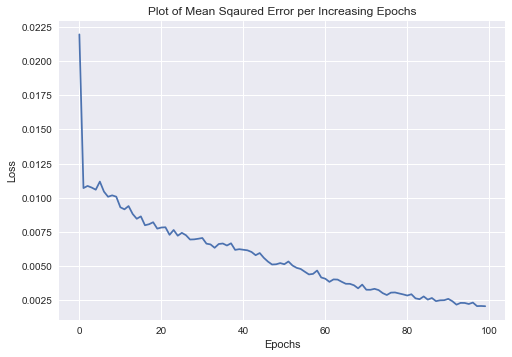

In [23]:
loss= model.history.history['loss']
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot of Mean Sqaured Error per Increasing Epochs')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 72, 120)           70080     
                                                                 
 dropout (Dropout)           (None, 72, 120)           0         
                                                                 
 lstm_1 (LSTM)               (None, 72, 170)           197880    
                                                                 
 dropout_1 (Dropout)         (None, 72, 170)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                44200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

### Testibg the Model Accuracy

In [25]:
## Predicting the test data
test_predict= model.predict(x_test)

## Getting actual test values
test_predict= scaler2.inverse_transform(test_predict)
returnss= scaler2.inverse_transform(y_test)

print('(Predicted)', '(Actual)')

for i in range(100):
    print(test_predict[i], returnss[i])

14/14 [==============================] - 3s 78ms/step
(Predicted) (Actual)
[0.97014165] [0.96164384]
[0.99795145] [0.99863201]
[1.0043896] [1.00550206]
[1.0001462] [0.99862637]
[1.0172867] [1.0153417]
[1.0215753] [1.01558074]
[0.9923657] [0.99296765]
[0.9782171] [0.97530864]
[0.9976504] [0.99726402]
[1.0048636] [1.00412088]
[1.0040908] [1.00552486]
[1.0156223] [1.0097629]
[1.0234886] [1.01991465]
[0.99200326] [0.98874824]
[0.9772549] [0.97530864]
[0.9901415] [0.98914518]
[1.0138216] [1.0179558]
[1.0011503] [1.0069541]
[0.99070585] [0.98224044]
[1.0004425] [1.00549451]
[0.9717329] [0.96296296]
[0.982305] [0.98565841]
[0.9885684] [0.98207426]
[1.0070412] [1.01428571]
[0.99767864] [0.99354839]
[1.0051074] [1.00780234]
[0.9937853] [0.99225806]
[0.9954206] [0.99614396]
[0.9969523] [0.9974359]
[0.9961544] [1.]
[1.0030955] [1.]
[1.0082992] [1.00645161]
[1.0030669] [1.00129199]
[1.0066605] [1.00259067]
[1.0086029] [1.01578947]
[0.9966092] [1.00396301]
[1.0204682] [1.01474531]
[1.0358273] [1.03

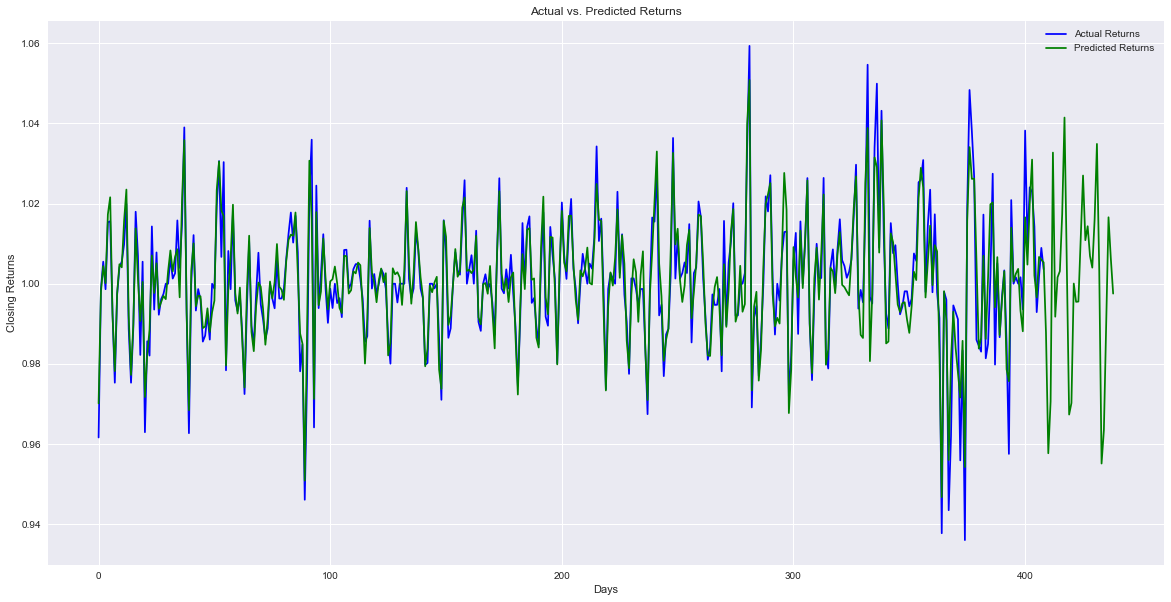

In [26]:
## Plotting the predictions
plt.figure(figsize= (20,10))
plt.plot(returnss, color= 'blue', label= 'Actual Returns', fontsize= )
plt.plot(test_predict[:], color= 'green', label= 'Predicted Returns')

plt.xlabel('Days')
plt.ylabel('Closing Returns')
plt.title('Actual vs. Predicted Returns')
plt.legend()

In [27]:
### Performance Accuracy Evaluation
print('rmse=', math.sqrt(mean_squared_error(returnss, test_predict[:len(test_predict)-30])))

rmse= 0.005650354998297079


In [28]:
## 30 Days Predictions 
forecasted= test_predict[len(test_predict)-30:]
print(forecasted)

[[0.9878326 ]
 [0.9577063 ]
 [0.9706571 ]
 [1.0327164 ]
 [0.99177694]
 [1.0015994 ]
 [1.0031234 ]
 [1.0173216 ]
 [1.041453  ]
 [1.0043225 ]
 [0.96735156]
 [0.9702475 ]
 [1.0000498 ]
 [0.9954783 ]
 [0.9955528 ]
 [1.0114511 ]
 [1.0269887 ]
 [1.010852  ]
 [1.0143468 ]
 [1.0069268 ]
 [1.0040134 ]
 [1.016034  ]
 [1.0348785 ]
 [1.0032551 ]
 [0.9551438 ]
 [0.9634458 ]
 [0.9903701 ]
 [1.0165734 ]
 [1.0062821 ]
 [0.9975413 ]]


In [27]:
np.mean(forecasted)

0.9993595